# Segment 2: Activation Maximization

**Goal:** Visualize what neurons in InceptionV1 are "looking for" by generating images that maximally activate them.

## What is Activation Maximization?

Instead of asking *"what does this neuron do when I show it an image?"*, we ask:

> **"What image would make this neuron fire the most?"**

We start with random noise and iteratively modify it via gradient ascent to maximize a neuron's activation. The result reveals what patterns that neuron detects.

## Tools
- **Lucent**: PyTorch port of Lucid (from the Circuits team)
- **InceptionV1**: The model used throughout the Circuits thread
- **Target**: First 10 neurons of `mixed4a` layer

In [2]:
# Cell 1: Setup
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "7"

import matplotlib
matplotlib.use('Agg')  # Non-interactive backend for server

import torch
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, Image
import io

def show_fig():
    """Display current matplotlib figure inline in notebook."""
    buf = io.BytesIO()
    plt.savefig(buf, format='png', bbox_inches='tight', dpi=100)
    buf.seek(0)
    display(Image(data=buf.read()))
    plt.close()

# Patch lucent for PyTorch 2.x compatibility (dtype mismatch fix)
import lucent.optvis.param.color as color_module
import numpy as np

def _patched_linear_decorrelate_color(tensor):
    batch, channels, height, width = tensor.shape
    # Flatten to [B*H*W, C] for simple 2D matmul
    t_flat = tensor.permute(0, 2, 3, 1).reshape(-1, channels)
    
    # Get color correlation matrix as contiguous numpy array, then convert
    cc = np.array(color_module.color_correlation_normalized.T, dtype=np.float32)
    color_matrix = torch.from_numpy(cc).to(dtype=tensor.dtype, device=tensor.device)
    
    # 2D matmul avoids batched CUBLAS issues
    result = torch.mm(t_flat, color_matrix)
    return result.reshape(batch, height, width, channels).permute(0, 3, 1, 2)

color_module._linear_decorrelate_color = _patched_linear_decorrelate_color

from lucent.modelzoo import inceptionv1
from lucent.optvis import render, objectives

print(f"Using: {torch.cuda.get_device_name(0)}")

model = inceptionv1(pretrained=True).cuda().eval()

print("\nKey layers:")
for name, _ in model.named_modules():
    if 'mixed' in name and '.' not in name:
        print(f"  {name}")

Using: NVIDIA H100 80GB HBM3

Key layers:
  mixed3a_1x1_pre_relu_conv
  mixed3a_3x3_bottleneck_pre_relu_conv
  mixed3a_5x5_bottleneck_pre_relu_conv
  mixed3a_pool_reduce_pre_relu_conv
  mixed3a_3x3_pre_relu_conv
  mixed3a_5x5_pre_relu_conv
  mixed3b_1x1_pre_relu_conv
  mixed3b_3x3_bottleneck_pre_relu_conv
  mixed3b_5x5_bottleneck_pre_relu_conv
  mixed3b_pool_reduce_pre_relu_conv
  mixed3b_3x3_pre_relu_conv
  mixed3b_5x5_pre_relu_conv
  mixed4a_1x1_pre_relu_conv
  mixed4a_3x3_bottleneck_pre_relu_conv
  mixed4a_5x5_bottleneck_pre_relu_conv
  mixed4a_pool_reduce_pre_relu_conv
  mixed4a_3x3_pre_relu_conv
  mixed4a_5x5_pre_relu_conv
  mixed4b_1x1_pre_relu_conv
  mixed4b_3x3_bottleneck_pre_relu_conv
  mixed4b_5x5_bottleneck_pre_relu_conv
  mixed4b_pool_reduce_pre_relu_conv
  mixed4b_3x3_pre_relu_conv
  mixed4b_5x5_pre_relu_conv
  mixed4c_1x1_pre_relu_conv
  mixed4c_3x3_bottleneck_pre_relu_conv
  mixed4c_5x5_bottleneck_pre_relu_conv
  mixed4c_pool_reduce_pre_relu_conv
  mixed4c_3x3_pre_relu_c

## Understanding `mixed4a`

`mixed4a` is a mid-level layer in InceptionV1. According to the Circuits research:

- **Earlier layers** (mixed3a/b): Detect textures, curves, simple shapes
- **mixed4a**: Detects parts and patterns (eyes, fur textures, wheels)
- **Later layers** (mixed5a/b): Detect objects and object parts

This layer is interesting because features are complex enough to be recognizable, but not so abstract that they're hard to visualize.

In [3]:
# Cell 2: Activation maximization for first 10 neurons of mixed4a
layer_name = "mixed4a"
num_neurons = 10
visualizations = []

print(f"Generating activation maximization for {layer_name}, neurons 0-{num_neurons-1}")

for i in range(num_neurons):
    print(f"  Neuron {i}...", end=" ", flush=True)
    obj = objectives.channel(layer_name, i)
    imgs = render.render_vis(model, obj, thresholds=(256,), show_inline=False, show_image=False, progress=False)
    visualizations.append(imgs[0][0])
    print("done")

# Clear any pending matplotlib state
plt.close('all')
# Sync CUDA to ensure all GPU ops complete
torch.cuda.synchronize()

print("\nComplete!")

Generating activation maximization for mixed4a, neurons 0-9
  Neuron 0... done
  Neuron 1... done
  Neuron 2... done
  Neuron 3... done
  Neuron 4... done
  Neuron 5... done
  Neuron 6... done
  Neuron 7... done
  Neuron 8... done
  Neuron 9... done

Complete!


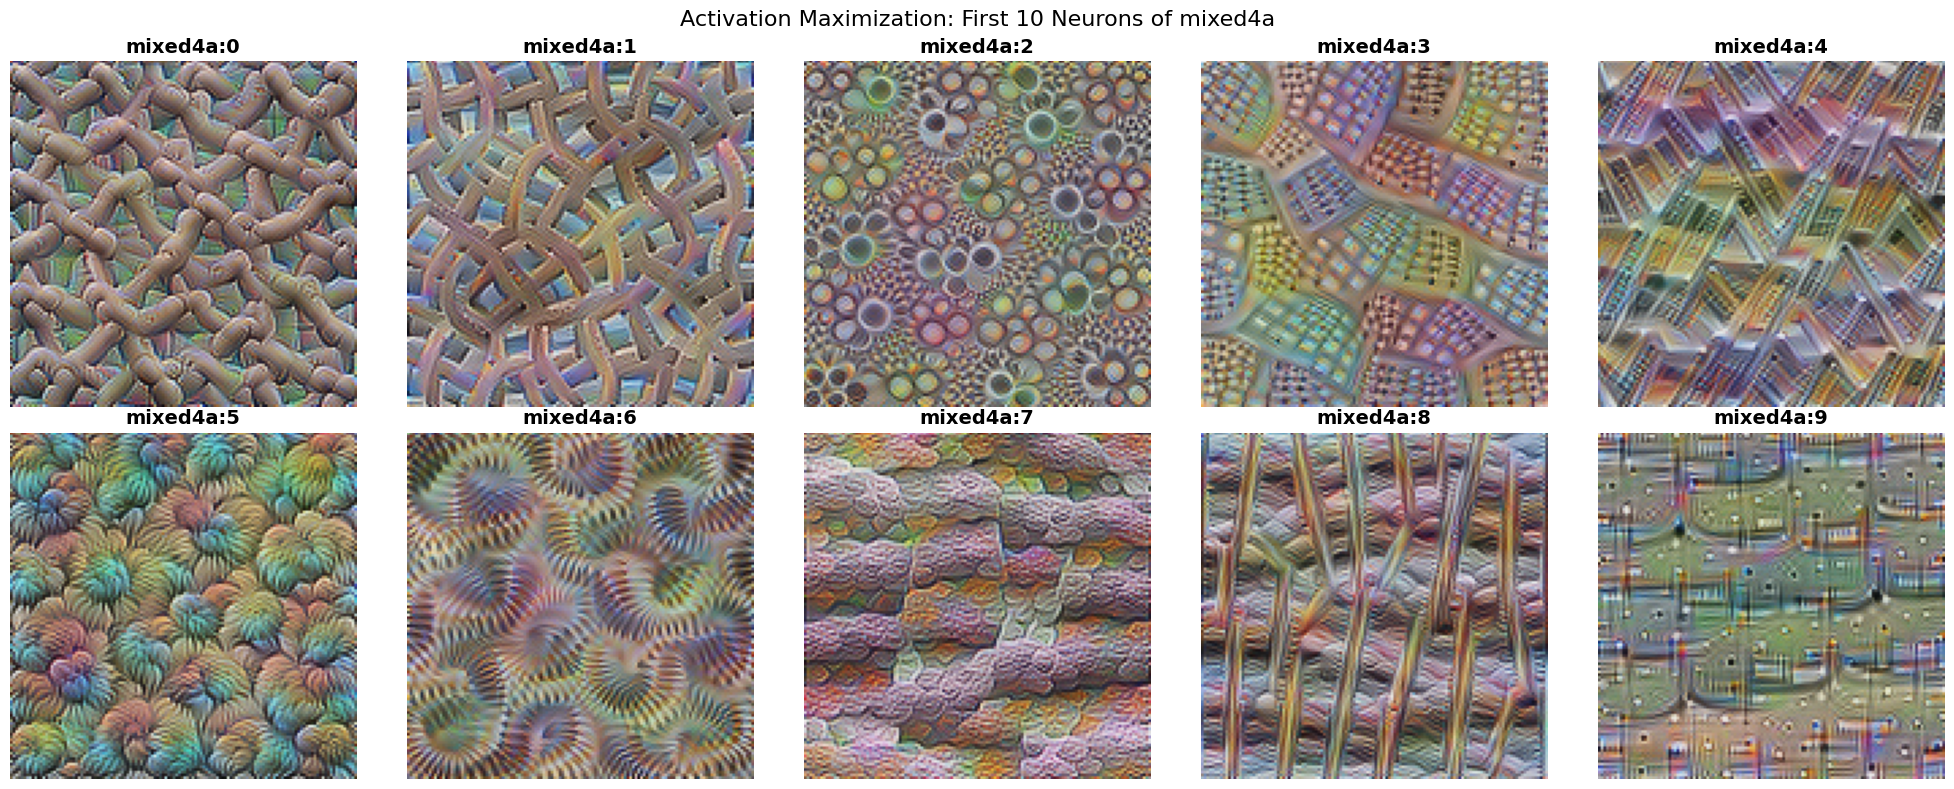

In [4]:
# Cell 3: Display results
fig, axes = plt.subplots(2, 5, figsize=(20, 8))

for idx, (ax, img) in enumerate(zip(axes.flat, visualizations)):
    ax.imshow(img)
    ax.set_title(f"{layer_name}:{idx}", fontsize=14, fontweight='bold')
    ax.axis('off')

plt.suptitle(f"Activation Maximization: First 10 Neurons of {layer_name}", fontsize=16)
plt.tight_layout()
show_fig()

## Interpreting the Results

Look at each visualization and try to identify what the neuron detects:

- **Textures**: Fur, scales, fabric patterns
- **Shapes**: Curves, circles, edges at specific orientations
- **Parts**: Eye-like shapes, body parts, object components
- **Abstract patterns**: Color gradients, frequency patterns

Some neurons may be **polysemantic** (respond to multiple unrelated things) - this is a known challenge discussed in the Circuits paper.

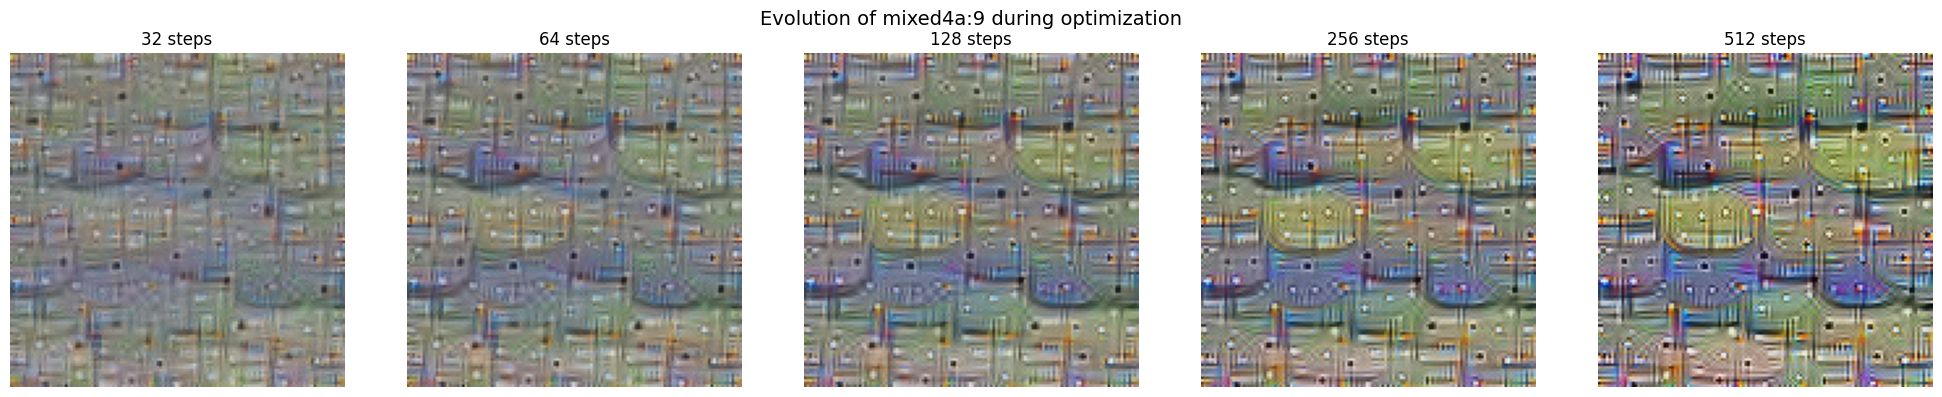

In [7]:
# Cell 4: Optimization evolution - watch features emerge
neuron = 9
steps = [32, 64, 128, 256, 512]

obj = objectives.channel(layer_name, neuron)
imgs = render.render_vis(model, obj, thresholds=steps, show_inline=False, show_image=False, progress=False)

fig, axes = plt.subplots(1, len(steps), figsize=(20, 4))
for ax, img, s in zip(axes, imgs, steps):
    ax.imshow(img[0])
    ax.set_title(f"{s} steps")
    ax.axis('off')

plt.suptitle(f"Evolution of {layer_name}:{neuron} during optimization", fontsize=14)
plt.tight_layout()
show_fig()

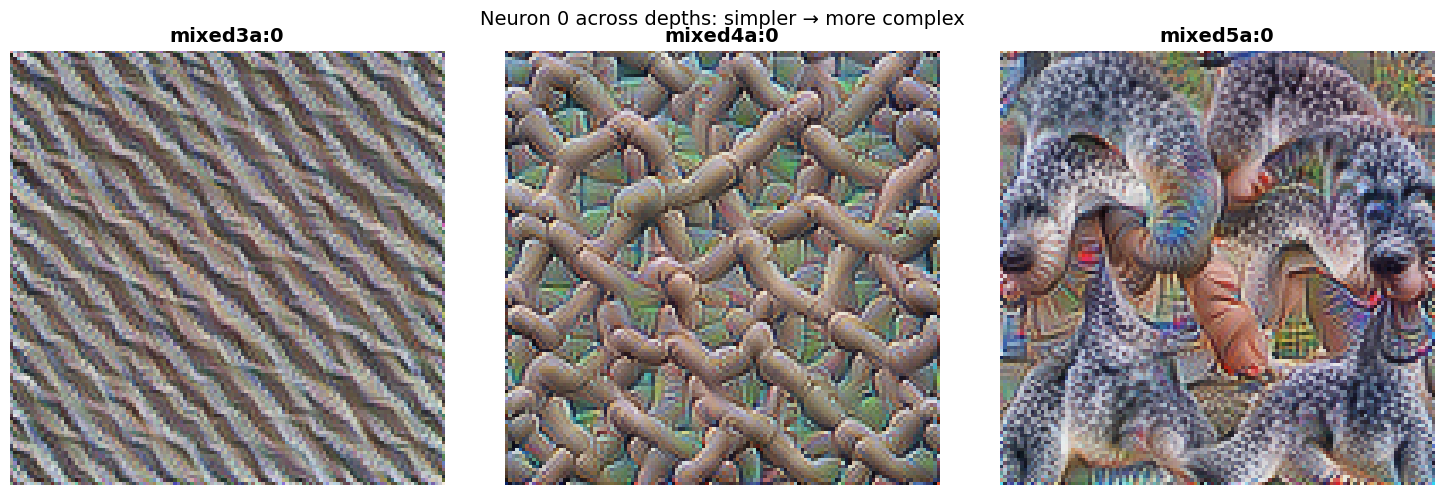

In [8]:
# Cell 5: Compare across layers - abstraction increases with depth
layers = ['mixed3a', 'mixed4a', 'mixed5a']

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for ax, layer in zip(axes, layers):
    obj = objectives.channel(layer, 0)
    imgs = render.render_vis(model, obj, thresholds=(256,), show_inline=False, show_image=False, progress=False)
    ax.imshow(imgs[0][0])
    ax.set_title(f"{layer}:0", fontsize=14, fontweight='bold')
    ax.axis('off')

plt.suptitle("Neuron 0 across depths: simpler → more complex", fontsize=14)
plt.tight_layout()
show_fig()

## Summary

**What we learned:**

1. **Activation maximization** reveals what neurons are "looking for"
2. **Lucent** makes this easy with `render_vis()` and `objectives.channel()`
3. **mixed4a** contains mid-level features - parts, textures, shapes
4. **Deeper layers** have more abstract, complex features

**Key observations from mixed4a neurons:**
- Some detect textures (fur, patterns)
- Some detect shapes (curves, edges)
- Some may be polysemantic (multiple patterns)

**Next steps in the Circuits thread:**
- Segment 3: Dataset examples (what real images activate these neurons?)
- Later: Circuit analysis (how are these neurons connected?)

---

**Reference:** [Zoom In: An Introduction to Circuits](https://distill.pub/2020/circuits/zoom-in/)